# Cross-Comparison between One-Shot and Myopic Models

James Yu, 29 July 2022

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
A_2 = np.array([
    [0.48, 0.3, 0.22],
    [0.3, 0.52, 0.18],
    [0.22, 0.18, 0.6]
])

In [3]:
eigvals_2, U_2 = np.linalg.eig(A_2)
eigvals_2

array([1.        , 0.19416995, 0.40583005])

In [4]:
delta = 0.9
c = 1.0
T = 1
x_0 = np.array([[10.0, 10.0, -20.0]], ndmin = 2).T
x_0

array([[ 10.],
       [ 10.],
       [-20.]])

Using unprojected opinions:

In [5]:
def one_shot(A, delta, c, T, x_0):
    I = np.identity(len(x_0))
    eigvals, U = np.linalg.eig(A)
    xs = [x_0]
    D = np.diag(eigvals)
    tilde_x_0 = U.T @ x_0
    print("L_0:")
    print(-delta * np.linalg.inv((c * I) + (delta * np.linalg.inv(I - (delta * (D @ D))))) @ np.linalg.inv(I - (delta * (D @ D))) @ D)
    tilde_r_0 = -delta * np.linalg.inv((c * I) + (delta * np.linalg.inv(I - (delta * (D @ D))))) @ np.linalg.inv(I - (delta * (D @ D))) @ D @ tilde_x_0
    tilde_x_t = D @ tilde_x_0 + tilde_r_0
    xs.append(U @ tilde_x_t)
    r_0 = U @ tilde_r_0
    print("r_0 =", r_0.T)
    for i in range(T-1):
        tilde_x_t = D @ tilde_x_t
        xs.append(U @ tilde_x_t)
        
    payoff = 0.0
    stage_payoffs = []
    discounted_stage_payoffs = []
    cumulative_payoffs = []
    
    payoff += -(x_0.T @ x_0).item() - (c * (r_0.T @ r_0).item())
    stage_payoffs.append(payoff)
    discounted_stage_payoffs.append(payoff)
    cumulative_payoffs.append(payoff)
    for i in range(1, T+1):
        stage_payoff = (xs[i].T @ xs[i]).item()
        stage_payoffs.append(-stage_payoff)
        discounted_stage_payoffs.append(-delta**i * stage_payoff)
        payoff += -delta**i * stage_payoff
        cumulative_payoffs.append(payoff)
      
    return xs, cumulative_payoffs

In [6]:
def myopic(A, delta, c, T, x_0):
    eigvals, U = np.linalg.eig(A)
    D = np.diag(eigvals)
    I = np.identity(len(x_0))
    
    tilde_x_0 = U.T @ x_0
    tilde_x_t = tilde_x_0
    r_ts = []
    x_ts = [x_0]
    L_m = (-delta / (delta + c)) * D
    print("L_m:")
    print(L_m)
    for i in range(T):
        tilde_r_t = L_m @ tilde_x_t
        tilde_x_t_new = D @ tilde_x_t + tilde_r_t
        
        x_t_new = U @ tilde_x_t_new
        x_ts.append(x_t_new)
        r_t = U @ tilde_r_t
        r_ts.append(r_t)
        
        tilde_x_t = tilde_x_t_new
        
    return x_ts, r_ts

In [7]:
def payoffs(xs, rs, delta, c, T, finite = True):
    stage_payoffs = []
    discounted_stage_payoffs = []
    cumulative_payoffs = []
    payoff = 0.0
    for i in range(T):
        stage_payoff = (xs[i].T @ xs[i]).item() + (c * (rs[i].T @ rs[i])).item()
        payoff += -delta**i * stage_payoff
        stage_payoffs.append(-stage_payoff)
        discounted_stage_payoffs.append(-delta**i * stage_payoff)
        cumulative_payoffs.append(payoff)

    if finite:
        stage_payoff_T = (xs[-1].T @ xs[-1]).item()
        payoff += -delta**T * stage_payoff_T
        stage_payoffs.append(-stage_payoff_T)
        discounted_stage_payoffs.append(-delta**i * stage_payoff_T)
        cumulative_payoffs.append(payoff)
        
    return cumulative_payoffs

In [8]:
one_xs_2, one_cumulative_payoffs_2 = one_shot(A_2, delta, c, T, x_0)

L_0:
[[-0.9         0.          0.        ]
 [ 0.         -0.09364768  0.        ]
 [ 0.          0.         -0.2085015 ]]
r_0 = [[-1.72779923 -2.37895922  4.10675844]]


In [9]:
x_sequence_2, r_sequence_2 = myopic(A_2, delta, c, T, x_0)

L_m:
[[-0.47368421 -0.         -0.        ]
 [-0.         -0.09197524 -0.        ]
 [-0.         -0.         -0.19223529]]


In [10]:
cumulative_payoffs_2 = payoffs(x_sequence_2, r_sequence_2, delta, c, T)

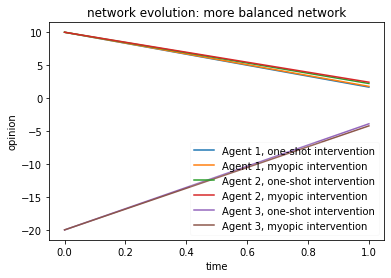

In [11]:
for i in range(3):
    plt.plot(range(len(one_xs_2)), [one_xs_2[j][i].item() for j in range(len(one_xs_2))], label = f"Agent {i+1}, one-shot intervention")
    plt.plot(range(len(x_sequence_2)), [x_sequence_2[j][i].item() for j in range(len(x_sequence_2))], label = f"Agent {i+1}, myopic intervention")
    
plt.xlabel("time")
plt.ylabel("opinion")
plt.title("network evolution: more balanced network")
plt.legend(framealpha = 0.1, loc = "lower right")
plt.show()

In [12]:
one_xs_2 # one-shot

[array([[ 10.],
        [ 10.],
        [-20.]]),
 array([[ 1.67220077],
        [ 2.22104078],
        [-3.89324156]])]

In [13]:
x_sequence_2 # myopic

[array([[ 10.],
        [ 10.],
        [-20.]]),
 array([[ 1.78947368],
        [ 2.42105263],
        [-4.21052632]])]

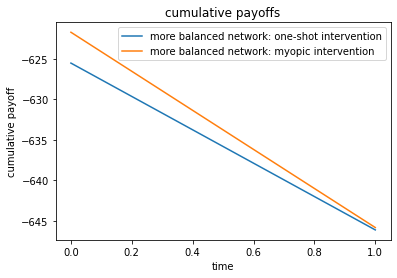

In [14]:
plt.plot(range(len(one_cumulative_payoffs_2)), one_cumulative_payoffs_2, label = "more balanced network: one-shot intervention")
plt.plot(range(len(cumulative_payoffs_2)), cumulative_payoffs_2, label = "more balanced network: myopic intervention")
plt.xlabel("time")
plt.ylabel("cumulative payoff")
plt.title("cumulative payoffs")
plt.legend()
plt.show()

In [15]:
r_sequence_2

[array([[-1.61052632],
        [-2.17894737],
        [ 3.78947368]])]

In [16]:
r_0 = [-1.72779923, -2.37895922,  4.10675844] # one-shot